## Preliminaries


**Definition (Value at Risk):**
The **Value at Risk (VaR)** of an investment is the maximal amount of money that is expected to be lost over a specified time horizon under *normal market conditions*, with a given confidence level. By financial convention, the time variable $t$ is measured in years unless otherwise stated.

---

**Definition (Asset Return and Asset Return Distribution):**
Let $V_t$ denote the value of an asset at time $t$. The **return** of the asset from time $t$ to $t+1$ is defined by

$$
R_t = \frac{V_{t+1} - V_t}{V_t}.
$$

The **asset return distribution** is the probability distribution governing the random variable $R_t$. In practice, this distribution is estimated using historical data, structural models, or simulation-based methods.

**Remark:** $V_t\in[0, \infty)$



#### **Problem:** In finance, how is VaR computed? And how do we measure it?



**Definition (Future Profit & Loss):** **Future profit & loss (P&L)** is the random change in the value of the asset (with value $V_t$) over future time horizon. In the context of our problem, the quantity we want to focus on is **loss**, which is defined as:
$$L_{t}=-R_{t}=-\left(\frac{V_{t+1}-V_t}{V_t}\right)$$

**Remark:** $L_t$'s are random variables.

---

**Definition (VaR):** Given a loss probability distribution $f_L:\mathbb{R}\to[0,1]$ (pdf of $L_t$'s) with a corresponding **cumulative density function** $F_L:\mathbb{R}\to[0,1]$, then the value at risk (VaR) is defined as

$$VaR_{1-\alpha} \equiv F_{L}^{-1}(\alpha)$$

where $\alpha\in(0,1)$ is the level of significance (so $1-\alpha$ is the confidence level).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

## 1. A First Hypothesis

A sensible guess for the asset return distribution is the gaussian distribution. Let $R_t \sim \mathscr{N}(\mu = 0.15, \sigma = 0.20)$.

Analytically,

\begin{align*}
VaR_{0.95} & = quantile_{0.95}(L_1, L_2, ...) \\
& = - quantile_{0.05}(R_1, R_2, ...) \\
& = -\left( \mu + z_{0.05}\sigma \right) \\
\end{align*}

In [ ]:
z_5 = stats.norm.ppf(0.05)
VaR_true = -(0.15 + z_5 * 0.20)
print("Analytic VaR (95%):", VaR_true)

Analytic VaR (95%): 0.1789707253902946


### 1.1 Monte Carlo Estimate of the VaR
The $N$-sample MC estimator of the VaR with 0.95 confidence level is defined as follows:

\begin{align*}
\widehat{VaR_{0.95}}(N) & =\operatorname{quantile}_{0.95}(L_1, L_2,...,L_N) \\
& = - \operatorname{quantile}_{0.05}(R_1, R_2, ..., R_N)
\end{align*}

We will first perform an MC estimation of the VaR with $N=1000$:

In [ ]:
def mc_var(N, mu=0.15, sigma=0.20, confidence=0.95):
    """
    Monte Carlo VaR estimator with N samples.
    Returns proportional VaR estimate.
    """
    # Step 1. Sample returns
    returns = np.random.normal(mu, sigma, size=N)

    # Step 2. Convert to losses
    losses = -returns

    # Step 3. Compute empirical quantile (VaR)
    VaR_est = np.quantile(losses, confidence)

    return VaR_est
print(f"N = 1000 -> MC VaR estimate = {mc_var(1000)}")

N = 1000 -> MC VaR estimate = 0.1628702583574344


### 1.2 Convergence of Monte Carlo VaR Estimates

Note that this is a notable difference between the MC estimate with $N=1000$ and the true VaR, what if we increase $N$?

N =     100   MC VaR = 0.139995
N =    1000   MC VaR = 0.179791
N =   10000   MC VaR = 0.176759
N =  100000   MC VaR = 0.176372
N = 1000000   MC VaR = 0.178612


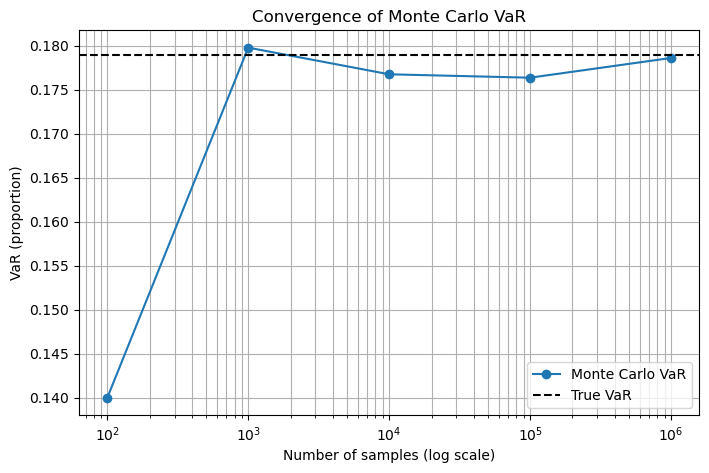

In [ ]:
# Define sample sizes
sample_sizes = [10**k for k in range(2, 7)]   # 10^2 to 10^6

mc_estimates = []

# Compute Monte Carlo VaR for each N
for N in sample_sizes:
    VaR_est = mc_var(N)   # uses your Step 4 function
    mc_estimates.append(VaR_est)
    print(f"N = {N:7d}   MC VaR = {VaR_est:.6f}")

# Graphical Comparison

plt.figure(figsize=(8,5))
plt.plot(sample_sizes, mc_estimates, marker='o', label="Monte Carlo VaR")
plt.axhline(VaR_true, color='black', linestyle='--', label="True VaR")

plt.xscale("log")
plt.xlabel("Number of samples (log scale)")
plt.ylabel("VaR (proportion)")
plt.title("Convergence of Monte Carlo VaR")
plt.grid(True, which="both")
plt.legend()
plt.show()

From the graph above, it is natural to make the following conjecture:

$$
\lim_{N\to\infty} \widehat{\mathrm{VaR}}_{0.95}(N) \to VaR_{0.95}
$$

## 1.3 Proof & Error Analysis

From this empirical convergence, we now justify theoretically why the Monte Carlo VaR estimator converges to the true VaR and why its error scales like $1/\sqrt{N}$.

Let $F_L(x) = P(L \le x)$ be the true cumulative distribution function (CDF) of the loss $L$.
Let $F_{L,N}(x)$ be the empirical CDF constructed from $N$ Monte Carlo samples:

$$
F_{L,N}(x) = \frac{1}{N} \sum_{i=1}^N 1_{\{L_i \le x\}}.
$$

Each indicator variable $1_{\{L_i \le x\}}$ is Bernoulli, so estimating $F_L(x)$ at a fixed
point $x$ is the same as estimating a sample mean. By the Central Limit Theorem,

$$
F_{L,N}(x) - F_L(x) = O\left( \frac{1}{\sqrt{N}} \right).
$$

The true $95\%$ Value-at-Risk (VaR) is the $0.95$ quantile of the loss distribution:

$$
\mathrm{VaR}_{95} = F_L^{-1}(0.95).
$$

The Monte Carlo estimator of the VaR is the empirical quantile:

$$
\widehat{\mathrm{VaR}}_{95}(N) = F_{L,N}^{-1}(0.95).
$$

---


The empirical CDF $F_{L,N}(x)$ differs from $F_L(x)$ by an amount of order $1/\sqrt{N}$.
This is a *vertical* error: the estimated probability at a fixed value $x$ is off by about
$\delta = O(1/\sqrt{N})$.

To understand how this affects the VaR estimate, recall that $F_L(x)$ is differentiable
near the true VaR, with density $f_L(x) = F_L'(x)$ that is strictly positive there.
By a first-order Taylor expansion around the VaR,

$$
F_L(x + h) \approx F_L(x) + f_L(x)\,h.
$$

If $F_{L,N}(x)$ shifts by $\delta$, then the corresponding horizontal shift in the
quantile is approximately

$$
h \approx \frac{\delta}{f_L(x)}.
$$

Since $\delta = O(1/\sqrt{N})$ and $f_L(x)$ is a nonzero constant at the VaR,
the quantile error satisfies

$$
\widehat{\mathrm{VaR}}_{95}(N)
    - \mathrm{VaR}_{95}
    = O\left( \frac{1}{\sqrt{N}} \right).
$$

Thus the Monte Carlo estimate of the VaR inherits the same $1/\sqrt{N}$ rate as
the empirical CDF from which it is derived.

---


If the VaR error behaves like $1/\sqrt{N}$, then achieving a target accuracy
$\epsilon$ requires

$$
\frac{1}{\sqrt{N}} \approx \epsilon.
$$

Solving for $N$ gives

$$
N = O\left( \frac{1}{\epsilon^2} \right).
$$

This means that to reduce the VaR error by a factor of $10$, we must increase the
number of Monte Carlo samples by a factor of $100$. This quadratic dependence is a
fundamental limitation of classical Monte Carlo and is precisely why quantum amplitude
estimation offers a potential advantage, with its $O(1/\epsilon)$ scaling.


AI generated:

In [ ]:
def classical_monte_carlo_var(mu=0.15, sigma=0.20, n_samples=1000, confidence_level=0.95, seed=None):
    """
    Classical Monte Carlo engine for Value at Risk estimation.

    Parameters:
    -----------
    mu : float
        Mean annual return (default: 0.15 or 15%)
    sigma : float
        Annual standard deviation (default: 0.20 or 20%)
    n_samples : int
        Number of Monte Carlo samples to generate
    confidence_level : float
        Confidence level for VaR (default: 0.95)
    seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    dict : Dictionary containing VaR estimate and samples
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate N random samples from N(mu, sigma^2)
    samples = np.random.normal(mu, sigma, n_samples)

    # Calculate the empirical percentile for VaR
    # VaR at confidence level α is the (1-α) percentile of losses
    # For 95% confidence, we want the 5th percentile
    percentile = (1 - confidence_level) * 100
    empirical_var = np.percentile(samples, percentile)

    return {
        'samples': samples,
        'empirical_var': empirical_var,
        'n_samples': n_samples,
        'percentile': percentile
    }

In [ ]:
def theoretical_var(mu=0.15, sigma=0.20, confidence_level=0.95):
    """
    Calculate theoretical VaR using the inverse CDF of normal distribution.

    Parameters:
    -----------
    mu : float
        Mean annual return
    sigma : float
        Annual standard deviation
    confidence_level : float
        Confidence level for VaR

    Returns:
    --------
    float : Theoretical VaR value
    """
    # For confidence level α, we want the (1-α) quantile
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(alpha)
    theoretical_var = mu + z_score * sigma

    return theoretical_var

In [ ]:
def convergence_study(mu=0.15, sigma=0.20, confidence_level=0.95,
                     sample_sizes=None, n_trials=50):
    """
    Study how estimated VaR converges to theoretical value as number of samples increases.
    Demonstrates the O(1/ε²) scaling of Monte Carlo error.

    Parameters:
    -----------
    mu : float
        Mean annual return
    sigma : float
        Annual standard deviation
    confidence_level : float
        Confidence level for VaR
    sample_sizes : list, optional
        List of sample sizes to test
    n_trials : int
        Number of trials for each sample size (to estimate variance)

    Returns:
    --------
    dict : Dictionary containing convergence results
    """
    if sample_sizes is None:
        sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

    # Calculate theoretical VaR
    true_var = theoretical_var(mu, sigma, confidence_level)

    # Store results
    mean_errors = []
    std_errors = []

    for n in sample_sizes:
        errors = []
        for trial in range(n_trials):
            result = classical_monte_carlo_var(mu, sigma, n, confidence_level)
            error = abs(result['empirical_var'] - true_var)
            errors.append(error)

        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))

    return {
        'sample_sizes': sample_sizes,
        'mean_errors': mean_errors,
        'std_errors': std_errors,
        'theoretical_var': true_var
    }

In [ ]:
def plot_convergence(convergence_results):
    """
    Plot convergence of Monte Carlo VaR estimate to theoretical value.
    Demonstrates O(1/ε²) scaling.
    """
    sample_sizes = np.array(convergence_results['sample_sizes'])
    mean_errors = np.array(convergence_results['mean_errors'])
    std_errors = np.array(convergence_results['std_errors'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Error vs Number of Samples (linear scale)
    ax1.errorbar(sample_sizes, mean_errors, yerr=std_errors,
                 marker='o', capsize=5, label='Empirical Error')
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.set_title('VaR Estimation Error vs Number of Samples')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Log-log plot to show O(1/√N) scaling
    ax2.loglog(sample_sizes, mean_errors, 'o-', label='Empirical Error')

    # Add theoretical O(1/√N) reference line
    # For Monte Carlo, error scales as O(1/√N)
    reference_line = mean_errors[0] * np.sqrt(sample_sizes[0] / sample_sizes)
    ax2.loglog(sample_sizes, reference_line, '--',
               label=r'$O(1/\sqrt{N})$ Reference', alpha=0.7)

    ax2.set_xlabel('Number of Samples (log scale)')
    ax2.set_ylabel('Mean Absolute Error (log scale)')
    ax2.set_title('Convergence Rate (Log-Log Scale)')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.legend()

    plt.tight_layout()
    return fig


CLASSICAL MONTE CARLO ENGINE FOR VALUE AT RISK

Theoretical VaR (95% confidence): -0.1790 (-17.90%)

----------------------------------------------------------------------
Single Monte Carlo Simulation with N=10,000 samples:
----------------------------------------------------------------------
Empirical VaR: -0.1810 (-18.10%)
Error: 0.0020

----------------------------------------------------------------------
Convergence Study (may take a moment...):
----------------------------------------------------------------------

Sample Size | Mean Error | Std Error
---------------------------------------------
         10 |   0.108830 |  0.070382
         50 |   0.046822 |  0.029333
        100 |   0.036641 |  0.025253
        500 |   0.017975 |  0.011743
      1,000 |   0.010201 |  0.006912
      5,000 |   0.004707 |  0.002840
     10,000 |   0.003817 |  0.001835
     50,000 |   0.001807 |  0.000981
    100,000 |   0.001088 |  0.000799

-----------------------------------------------------

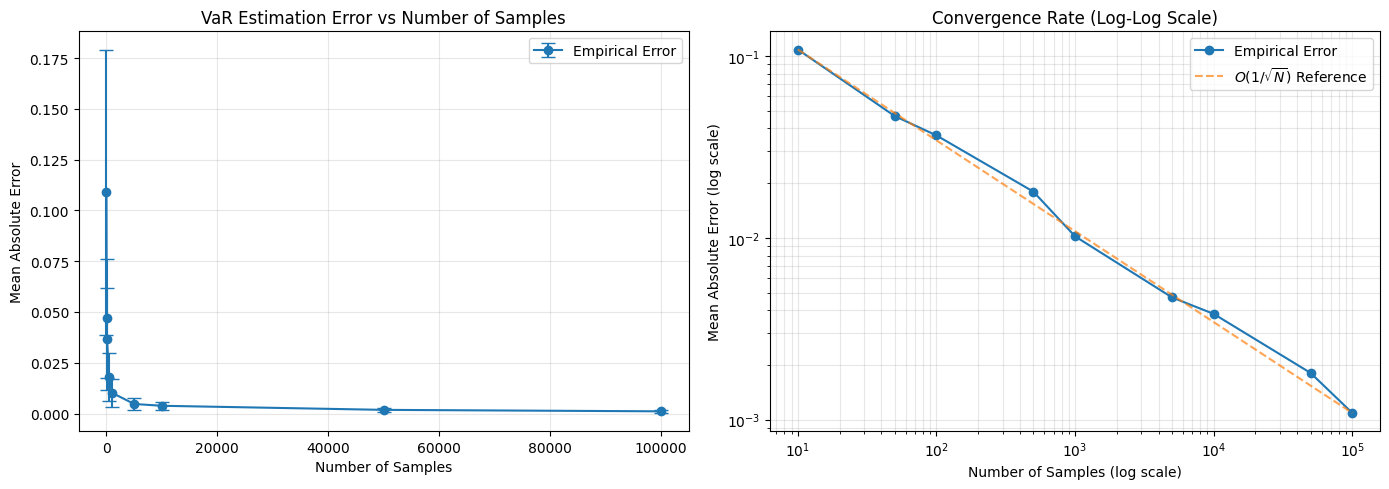

In [ ]:
# Main demonstration
if __name__ == "__main__":
    print("\n" + "="*70)
    print("CLASSICAL MONTE CARLO ENGINE FOR VALUE AT RISK")
    print("="*70)

    # Parameters matching the challenge: Gaussian with mean 15%, std 20%
    mu = 0.15
    sigma = 0.20
    confidence_level = 0.95

    # 1. Calculate theoretical VaR
    true_var = theoretical_var(mu, sigma, confidence_level)
    print(f"\nTheoretical VaR (95% confidence): {true_var:.4f} ({true_var*100:.2f}%)")

    # 2. Single Monte Carlo simulation
    print("\n" + "-"*70)
    print("Single Monte Carlo Simulation with N=10,000 samples:")
    print("-"*70)
    result = classical_monte_carlo_var(mu, sigma, n_samples=10000,
                                       confidence_level=confidence_level, seed=42)
    print(f"Empirical VaR: {result['empirical_var']:.4f} ({result['empirical_var']*100:.2f}%)")
    print(f"Error: {abs(result['empirical_var'] - true_var):.4f}")

    # 3. Convergence study
    print("\n" + "-"*70)
    print("Convergence Study (may take a moment...):")
    print("-"*70)
    conv_results = convergence_study(mu, sigma, confidence_level, n_trials=30)

    print("\nSample Size | Mean Error | Std Error")
    print("-" * 45)
    for n, mean_err, std_err in zip(conv_results['sample_sizes'],
                                     conv_results['mean_errors'],
                                     conv_results['std_errors']):
        print(f"{n:>11,} | {mean_err:>10.6f} | {std_err:>9.6f}")

    # 4. Create visualization
    print("\n" + "-"*70)
    print("Generating convergence plot...")
    print("-"*70)
    fig = plot_convergence(conv_results)

    # Save to current working directory
    output_path = os.path.join(os.getcwd(), 'var_convergence.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Plot saved to: {output_path}")

    # 6. Demonstrate O(1/ε²) scaling
    print("\n" + "="*70)
    print("MONTE CARLO ERROR SCALING: O(1/ε²)")
    print("="*70)
    print("\nFor Monte Carlo methods:")
    print("  - Error decreases as O(1/√N)")
    print("  - To halve the error, you need 4× more samples")
    print("  - To achieve error ε, you need O(1/ε²) samples")
    print("\nThis is evident in the log-log plot where the error follows")
    print("a slope of -1/2, confirming the O(1/√N) convergence rate.")
    print("="*70)

    plt.show()

# FIXED CODE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# =============================================================================
# PARAMETERS (consistent with hackathon: N(0.15, 0.20^2))
# =============================================================================
MU = 0.15          # Expected annual return
SIGMA = 0.20       # Annual volatility
CONFIDENCE = 0.95  # VaR confidence level
ALPHA = 1 - CONFIDENCE  # 0.05 tail
PORTFOLIO_VALUE = 1_000_000  # $1M notional
N_SIMULATIONS = 100_000
SEED = 42

In [ ]:
# =============================================================================
# STEP 1: SINGLE-FACTOR RISK MODEL
# =============================================================================
# Stock return R = mu + beta * F + epsilon
#   F ~ N(0, sigma_m^2)       <- market factor
#   epsilon ~ N(0, sigma_e^2) <- idiosyncratic
#   Var(R) = beta^2 * sigma_m^2 + sigma_e^2 = SIGMA^2
#
# We pick a decomposition. Beta=1.2, sigma_m=0.14 are reasonable defaults;
# sigma_e is then solved so total vol = SIGMA.
# =============================================================================

BETA = 1.2
SIGMA_M = 0.14  # market factor volatility

# Solve for idiosyncratic vol: sigma_e = sqrt(SIGMA^2 - beta^2 * sigma_m^2)
SIGMA_E = np.sqrt(SIGMA**2 - BETA**2 * SIGMA_M**2)


def fit_factor_model(historical_returns, market_returns):
    """
    Fit the single-factor model from historical data via OLS.

    R_i = alpha + beta * F_i + epsilon_i

    Parameters
    ----------
    historical_returns : 1D array
        Observed stock returns over N historical periods.
    market_returns : 1D array
        Observed market factor returns over same N periods.

    Returns
    -------
    dict with fitted alpha, beta, sigma_e, and residuals.
    """
    # OLS: beta = Cov(R, F) / Var(F),  alpha = mean(R) - beta * mean(F)
    cov_matrix = np.cov(historical_returns, market_returns)
    beta_hat = cov_matrix[0, 1] / cov_matrix[1, 1]
    alpha_hat = np.mean(historical_returns) - beta_hat * np.mean(market_returns)

    residuals = historical_returns - (alpha_hat + beta_hat * market_returns)
    sigma_e_hat = np.std(residuals, ddof=1)

    return {
        "alpha": alpha_hat,
        "beta": beta_hat,
        "sigma_e": sigma_e_hat,
        "residuals": residuals,
    }



In [ ]:
# =============================================================================
# STEP 2: SIMULATE SCENARIOS (single 1-year horizon, not a time series)
# =============================================================================

def simulate_scenarios(alpha, beta, sigma_m, sigma_e, n_sims=N_SIMULATIONS, seed=SEED):
    """
    Draw n_sims independent 1-year scenarios.

    Each scenario: R = alpha + beta * F + epsilon
        F       ~ N(0, sigma_m^2)
        epsilon ~ N(0, sigma_e^2)

    Returns
    -------
    dict with market factor draws, idiosyncratic draws, and total returns.
    """
    rng = np.random.default_rng(seed)

    F = rng.normal(0, sigma_m, n_sims)           # market factor
    eps = rng.normal(0, sigma_e, n_sims)         # idiosyncratic
    returns = alpha + beta * F + eps             # total stock return

    return {
        "F": F,
        "eps": eps,
        "returns": returns,
    }


In [ ]:
# =============================================================================
# STEP 3: REPRICE PORTFOLIO -> SIMULATED LOSSES
# =============================================================================

def compute_losses(simulated_returns, portfolio_value=PORTFOLIO_VALUE):
    """
    Convert simulated returns to dollar P&L losses.

    Loss is defined as negative P&L (positive number = money lost).
        P&L_i   = portfolio_value * R_i
        Loss_i  = -P&L_i

    Parameters
    ----------
    simulated_returns : 1D array
    portfolio_value : float

    Returns
    -------
    1D array of losses (positive = bad).
    """
    pnl = portfolio_value * simulated_returns
    losses = -pnl  # flip sign so large positive loss = tail risk
    return losses



In [ ]:
# =============================================================================
# STEP 4: VaR = ALPHA-QUANTILE OF SIMULATED LOSSES
# =============================================================================

def estimate_var(losses, alpha=ALPHA):
    """
    VaR at confidence level (1-alpha) is the (1-alpha)-quantile of the loss
    distribution.  E.g. alpha=0.05 -> 95th percentile of losses.

    This is the threshold such that only alpha fraction of outcomes have
    losses exceeding it.  A positive VaR = real money at risk in the tail.
    A negative VaR = even the 95th-percentile outcome is still a gain.
    """
    return np.quantile(losses, 1 - alpha)


def theoretical_var_normal(mu=MU, sigma=SIGMA, portfolio_value=PORTFOLIO_VALUE, alpha=ALPHA):
    """
    Closed-form VaR for a normal return distribution (benchmark).
    Loss = -portfolio_value * R, so Loss ~ N(-pv*mu, (pv*sigma)^2)
    VaR = (1-alpha)-quantile of Loss distribution, matching estimate_var.
    """
    loss_mean = -portfolio_value * mu
    loss_std = portfolio_value * sigma
    return stats.norm.ppf(1 - alpha, loc=loss_mean, scale=loss_std)

In [ ]:
# =============================================================================
# BACKTESTING: rolling-window check of VaR coverage
# =============================================================================

def generate_synthetic_history(n_periods=500, seed=0):
    """
    Generate synthetic historical stock + market returns for backtesting.
    Uses the true factor model parameters so the backtest is self-consistent.
    """
    rng = np.random.default_rng(seed)
    F = rng.normal(0, SIGMA_M, n_periods)
    eps = rng.normal(0, SIGMA_E, n_periods)
    # alpha here = mu (since E[F]=0, E[R] = alpha)
    stock_returns = MU + BETA * F + eps
    market_returns = F + rng.normal(0, 0.02, n_periods)  # noisy market proxy
    return stock_returns, market_returns


def backtest_var(stock_returns, market_returns,
                 fit_window=252, alpha=ALPHA, n_sims=50_000, seed=SEED):
    """
    Rolling-window backtest.

    For each window:
        1. Fit the factor model on the past `fit_window` observations.
        2. Simulate scenarios -> losses -> compute VaR.
        3. Compare VaR to the NEXT realized loss (out-of-sample).
        4. Record whether the realized loss breached VaR (exceedance).

    A well-calibrated model should have an exceedance rate ≈ alpha.

    Returns
    -------
    dict with dates, predicted VaRs, realized losses, and exceedance flags.
    """
    n = len(stock_returns)
    predicted_vars = []
    realized_losses = []
    exceedances = []

    for t in range(fit_window, n - 1):
        # --- fit on history up to t ---
        hist_stock = stock_returns[t - fit_window:t]
        hist_market = market_returns[t - fit_window:t]
        fitted = fit_factor_model(hist_stock, hist_market)

        # --- simulate & price ---
        sims = simulate_scenarios(
            alpha=fitted["alpha"],
            beta=fitted["beta"],
            sigma_m=SIGMA_M,          # market vol assumed known (or could estimate)
            sigma_e=fitted["sigma_e"],
            n_sims=n_sims,
            seed=seed + t,            # different seed each window
        )
        losses = compute_losses(sims["returns"])
        var_t = estimate_var(losses, alpha)

        # --- next realized loss ---
        realized_loss_t = -PORTFOLIO_VALUE * stock_returns[t + 1]

        predicted_vars.append(var_t)
        realized_losses.append(realized_loss_t)
        exceedances.append(1 if realized_loss_t > var_t else 0)

    exceedance_rate = np.mean(exceedances)

    return {
        "predicted_vars": np.array(predicted_vars),
        "realized_losses": np.array(realized_losses),
        "exceedances": np.array(exceedances),
        "exceedance_rate": exceedance_rate,
        "target_rate": alpha,
    }



In [ ]:
# =============================================================================
# CONVERGENCE STUDY: VaR estimation error vs number of simulations
# =============================================================================

def convergence_study(fitted, sample_sizes=None, n_trials=30):
    """
    For each sample size N, run the full pipeline (simulate -> losses -> VaR)
    n_trials times and measure |simulated_VaR - theoretical_VaR|.

    Parameters
    ----------
    fitted : dict
        Output of fit_factor_model (alpha, beta, sigma_e).
    sample_sizes : list of int
        Simulation counts to sweep over.
    n_trials : int
        Number of independent runs per sample size.

    Returns
    -------
    dict with sample_sizes, mean_errors, std_errors, theoretical_var.
    """
    if sample_sizes is None:
        sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

    true_var = theoretical_var_normal()
    mean_errors = []
    std_errors = []

    for n in sample_sizes:
        errors = []
        for trial in range(n_trials):
            sims = simulate_scenarios(
                alpha=fitted["alpha"],
                beta=fitted["beta"],
                sigma_m=SIGMA_M,
                sigma_e=fitted["sigma_e"],
                n_sims=n,
                seed=SEED + trial * 1000 + n,  # unique seed per (n, trial)
            )
            losses = compute_losses(sims["returns"])
            var_est = estimate_var(losses)
            errors.append(abs(var_est - true_var))

        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))

    return {
        "sample_sizes": np.array(sample_sizes),
        "mean_errors": np.array(mean_errors),
        "std_errors": np.array(std_errors),
        "theoretical_var": true_var,
    }



In [ ]:
# =============================================================================
# PLOTTING
# =============================================================================

def plot_convergence(convergence_results):
    """
    Two-panel convergence plot, both using log base 2.

    Left:  VaR estimation error vs number of samples (log2 y-axis).
    Right: Log-log convergence rate with O(1/sqrt(N)) reference line
           (both axes log base 2).
    """
    N = convergence_results["sample_sizes"]
    mean_err = convergence_results["mean_errors"]
    std_err = convergence_results["std_errors"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left panel: error vs N, log2 y-axis ---
    ax1.errorbar(N, mean_err, yerr=std_err, marker="o", capsize=5,
                 color="steelblue", label="Mean Abs Error")
    ax1.set_yscale("log", base=2)
    ax1.set_xlabel("Number of Simulations")
    ax1.set_ylabel("VaR Estimation Error ($)  [log₂]")
    ax1.set_title("VaR Estimation Error vs Number of Samples")
    ax1.grid(True, alpha=0.3, which="both")
    ax1.legend()

    # --- Right panel: log-log (base 2 on both axes) ---
    ax2.loglog(N, mean_err, "o-", color="steelblue", label="Empirical Error", base=2)

    # O(1/sqrt(N)) reference line, anchored to first point
    reference = mean_err[0] * np.sqrt(N[0] / N)
    ax2.loglog(N, reference, "--", color="orange", alpha=0.7,
               label=r"$O(1/\sqrt{N})$ reference", base=2)

    ax2.set_xlabel("Number of Simulations  [log₂]")
    ax2.set_ylabel("VaR Estimation Error ($)  [log₂]")
    ax2.set_title("Convergence Rate (Log₂-Log₂ Scale)")
    ax2.grid(True, alpha=0.3, which="both")
    ax2.legend()

    plt.tight_layout()
    return fig


def plot_loss_distribution(losses, var_value, theoretical_var_value):
    """Plot the simulated loss distribution with VaR lines."""
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.hist(losses, bins=200, density=True, alpha=0.6, color="steelblue", label="Simulated Losses")
    ax.axvline(var_value, color="red", linewidth=2, linestyle="--",
               label=f"Simulated VaR ({CONFIDENCE*100:.0f}%): ${var_value:,.0f}")
    ax.axvline(theoretical_var_value, color="orange", linewidth=2, linestyle="-.",
               label=f"Theoretical VaR ({CONFIDENCE*100:.0f}%): ${theoretical_var_value:,.0f}")
    ax.axvline(0, color="gray", linewidth=0.8, linestyle=":")

    ax.set_xlabel("Loss ($)")
    ax.set_ylabel("Density")
    ax.set_title("Simulated Loss Distribution — Single-Factor Monte Carlo VaR")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def plot_backtest(backtest_results):
    """Plot backtest: predicted VaR vs realized losses, highlight exceedances."""
    pv = backtest_results["predicted_vars"]
    rl = backtest_results["realized_losses"]
    exc = backtest_results["exceedances"]
    t = np.arange(len(pv))

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(t, pv, color="red", linewidth=1.2, label="Predicted VaR")
    ax.plot(t, rl, color="steelblue", linewidth=0.7, alpha=0.7, label="Realized Loss")

    # Mark exceedances
    exc_idx = np.where(exc == 1)[0]
    ax.scatter(exc_idx, rl[exc_idx], color="black", s=30, zorder=5, label="Exceedance (breach)")

    ax.axhline(0, color="gray", linewidth=0.6, linestyle=":")
    ax.set_xlabel("Rolling Window Index")
    ax.set_ylabel("Loss ($)")
    ax.set_title(
        f"Backtest: VaR vs Realized Losses\n"
        f"Exceedance rate: {backtest_results['exceedance_rate']*100:.2f}% "
        f"(target: {backtest_results['target_rate']*100:.1f}%)"
    )
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig



SINGLE-FACTOR MONTE CARLO VaR MODEL

[Model Parameters]
  Stock return:   R ~ N(0.15, 0.2²)
  Factor model:   R = alpha + 1.2 * F + eps
  Market vol:     sigma_m = 0.14
  Idiosyn vol:    sigma_e = 0.1085
  Total vol check: sqrt(beta²·sigma_m² + sigma_e²) = 0.2000  (should be 0.2)
  Portfolio:      $1,000,000
  Confidence:     95%
  Simulations:    100,000

[Step 1] Fitting factor model from synthetic historical data...
  Fitted alpha: 0.1412  (true: 0.15)
  Fitted beta:  1.1733  (true: 1.2)
  Fitted sigma_e: 0.1053  (true: 0.1085)

[Step 2] Simulating scenarios...
  Simulated 100,000 1-year return scenarios.
  Mean return: 0.1408, Std: 0.1956

[Step 3] Computing portfolio losses...
  Mean loss:  $ -140,796.03
  Std loss:   $  195,635.98
  Min loss:   $-1,054,874.66  (best case = big gain)
  Max loss:   $  708,805.54  (worst case)

[Step 4] Estimating VaR...
  Simulated VaR (95%):   $  181,902.79
  Theoretical VaR (95%): $  178,970.73
  Difference:            $    2,932.06

  -> Saved: 

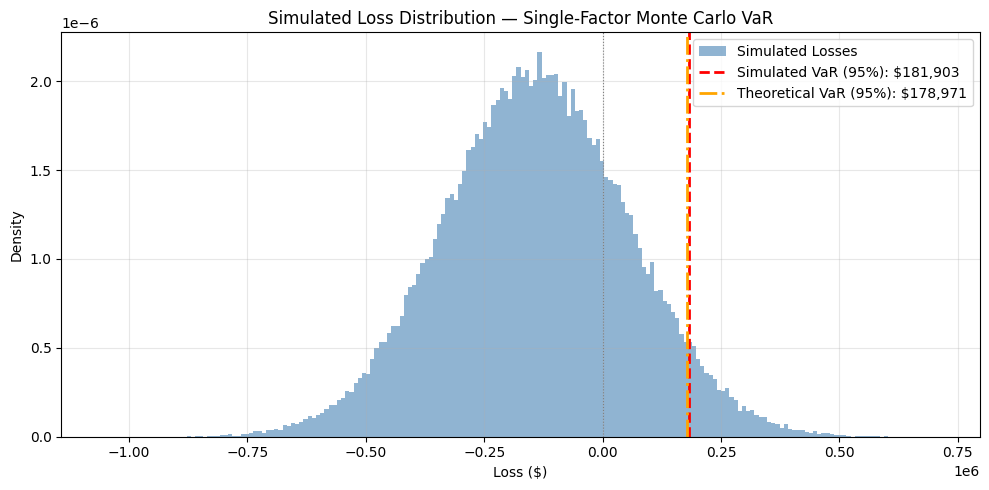

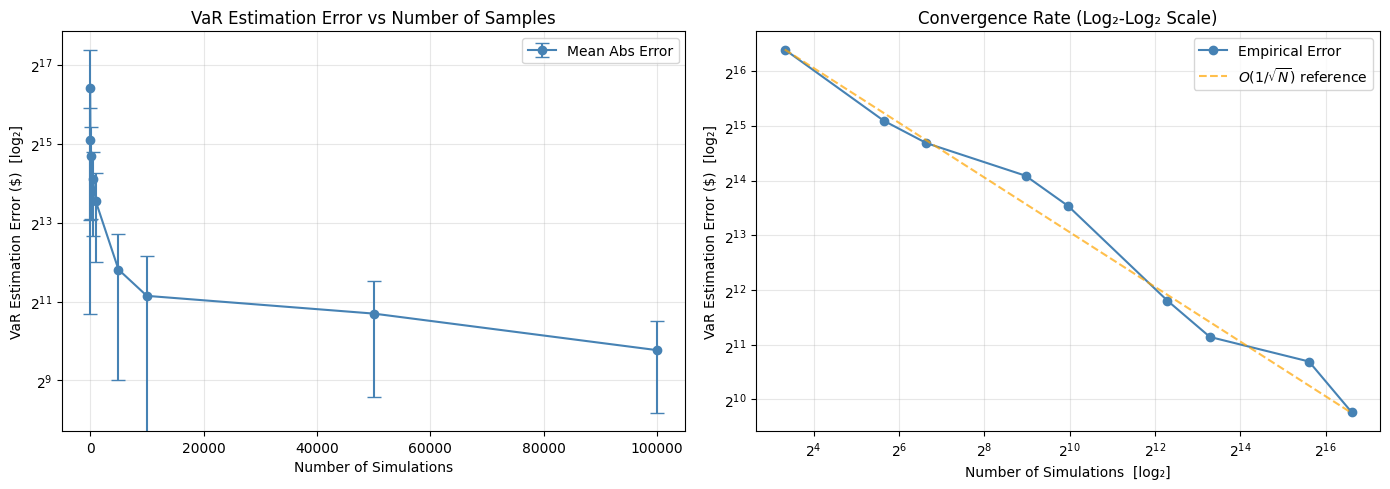

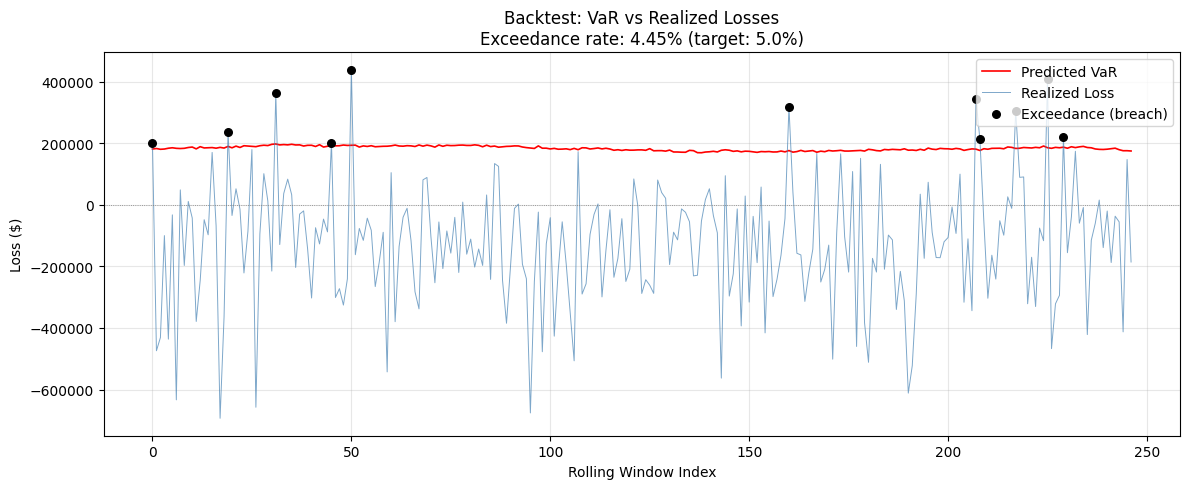

In [ ]:
# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("SINGLE-FACTOR MONTE CARLO VaR MODEL")
    print("=" * 70)

    # --- Model parameters ---
    print("\n[Model Parameters]")
    print(f"  Stock return:   R ~ N({MU}, {SIGMA}²)")
    print(f"  Factor model:   R = alpha + {BETA} * F + eps")
    print(f"  Market vol:     sigma_m = {SIGMA_M}")
    print(f"  Idiosyn vol:    sigma_e = {SIGMA_E:.4f}")
    print(f"  Total vol check: sqrt(beta²·sigma_m² + sigma_e²) = "
          f"{np.sqrt(BETA**2 * SIGMA_M**2 + SIGMA_E**2):.4f}  (should be {SIGMA})")
    print(f"  Portfolio:      ${PORTFOLIO_VALUE:,}")
    print(f"  Confidence:     {CONFIDENCE*100:.0f}%")
    print(f"  Simulations:    {N_SIMULATIONS:,}")

    # --- Step 1: Fit from synthetic history ---
    print("\n[Step 1] Fitting factor model from synthetic historical data...")
    stock_hist, market_hist = generate_synthetic_history(n_periods=500)
    fitted = fit_factor_model(stock_hist, market_hist)
    print(f"  Fitted alpha: {fitted['alpha']:.4f}  (true: {MU})")
    print(f"  Fitted beta:  {fitted['beta']:.4f}  (true: {BETA})")
    print(f"  Fitted sigma_e: {fitted['sigma_e']:.4f}  (true: {SIGMA_E:.4f})")

    # --- Step 2: Simulate scenarios ---
    print("\n[Step 2] Simulating scenarios...")
    sims = simulate_scenarios(
        alpha=fitted["alpha"],
        beta=fitted["beta"],
        sigma_m=SIGMA_M,
        sigma_e=fitted["sigma_e"],
    )
    print(f"  Simulated {len(sims['returns']):,} 1-year return scenarios.")
    print(f"  Mean return: {np.mean(sims['returns']):.4f}, Std: {np.std(sims['returns']):.4f}")

    # --- Step 3: Reprice -> losses ---
    print("\n[Step 3] Computing portfolio losses...")
    losses = compute_losses(sims["returns"])
    print(f"  Mean loss:  ${np.mean(losses):>12,.2f}")
    print(f"  Std loss:   ${np.std(losses):>12,.2f}")
    print(f"  Min loss:   ${np.min(losses):>12,.2f}  (best case = big gain)")
    print(f"  Max loss:   ${np.max(losses):>12,.2f}  (worst case)")

    # --- Step 4: VaR ---
    print("\n[Step 4] Estimating VaR...")
    var_sim = estimate_var(losses)
    var_theo = theoretical_var_normal()
    print(f"  Simulated VaR (95%):   ${var_sim:>12,.2f}")
    print(f"  Theoretical VaR (95%): ${var_theo:>12,.2f}")
    print(f"  Difference:            ${abs(var_sim - var_theo):>12,.2f}")

    # --- Plot loss distribution ---
    fig1 = plot_loss_distribution(losses, var_sim, var_theo)
    fig1.savefig("var_loss_distribution.png", dpi=150, bbox_inches="tight")
    print("\n  -> Saved: var_loss_distribution.png")

    # --- Convergence study ---
    print("\n[Convergence] Running convergence study (may take a moment)...")
    conv = convergence_study(fitted)

    print("\n  Sample Size |  Mean Error ($) |  Std Error ($)")
    print("  " + "-" * 50)
    for n, me, se in zip(conv["sample_sizes"], conv["mean_errors"], conv["std_errors"]):
        print(f"  {n:>11,} | {me:>15,.2f} | {se:>13,.2f}")

    fig_conv = plot_convergence(conv)
    fig_conv.savefig("var_convergence.png", dpi=150, bbox_inches="tight")
    print("\n  -> Saved: var_convergence.png")

    # --- Backtest ---
    print("\n[Backtest] Running rolling-window backtest...")
    bt = backtest_var(stock_hist, market_hist, fit_window=252)
    print(f"  Exceedance rate: {bt['exceedance_rate']*100:.2f}%  (target: {bt['target_rate']*100:.1f}%)")
    if abs(bt['exceedance_rate'] - bt['target_rate']) < 0.02:
        print("  ✓ Model is well-calibrated (within 2% of target).")
    else:
        print("  ✗ Model may be mis-calibrated — check assumptions.")

    fig2 = plot_backtest(bt)
    fig2.savefig("var_backtest.png", dpi=150, bbox_inches="tight")
    print("  -> Saved: var_backtest.png")

    print("\n" + "=" * 70)
    print("DONE")
    print("=" * 70)

    plt.show()

**Quantum Algorithms**